##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF Hub for TF2: Image Module Retraining (preview)

<table align="left">
<td align="center">
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /><br>Run in Google Colab
  </a>
</td>
<td align="center">
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /><br>View source on GitHub</a>
</td>
</table>

This Colab demonstrates the use of TF2 SavedModels found on TensorFlow Hub with Keras. It uses a pre-trained image feature vector module for classifying five species of flowers, including fine-tuning of the module.

## Set up TensorFlow 2 and other libraries

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import pathlib

import pandas as pd


print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


TF version: 2.0.0
Hub version: 0.6.0
GPU is available


## Select the Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [3]:
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4 with input size (299, 299)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [3]:
data_dir = tf.keras.utils.get_file(
    'Dataset',
#     'gs://labidub/Dataset.tar.gz',
    'https://console.cloud.google.com/storage/browser/labidub/Dataset.tar.gz',
    untar=True)

  73728/Unknown - 0s 0us/step

In [4]:
!gsutil cp gs://labidub/Dataset_Fill.tar.gz .
!tar xzf Dataset_Fill.tar.gz

Copying gs://labidub/Dataset_Fill.tar.gz...
| [1 files][  4.2 GiB/  4.2 GiB]   82.4 MiB/s                                   
Operation completed over 1 objects/4.2 GiB.                                      


In [5]:
!gsutil cp gs://labidub/Dataset.tar.gz .
!tar xzf Dataset.tar.gz

Copying gs://labidub/Dataset.tar.gz...
- [1 files][  1.5 GiB/  1.5 GiB]  110.7 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


In [4]:
pwd

'/home/jupyter/labidub/unimodal-image/hub/examples/colab'

In [8]:
data_dir = pathlib.Path('/home/jupyter/labidub/unimodal-image/flower_photos')


In [6]:
data_dir = pathlib.Path('./Dataset_Fill')
data_dir=str(data_dir)

In [7]:
# ls  . | sed -e 's/\(.*\)/train\/\1/g' | xargs mkdir -p 
# ls  . | sed -e 's/\(.*\)/test\/\1/g' | xargs mkdir -p 

In [13]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
test_generator = test_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

Found 25196 images belonging to 54 classes.


In [27]:
import os
import re
# os.rename("path/to/current/file.foo", "path/to/new/destination/for/file.foo")



In [26]:
train_generator = test_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=False, **dataflow_kwargs)

In [29]:
data_dir

'Dataset_Fill'

In [30]:
data_dir = "Dataset_Fill/train"
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
    train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 20148 images belonging to 52 classes.
Found 80656 images belonging to 52 classes.



## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [31]:
do_fine_tuning = True #@param {type:"boolean"}

In [32]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  21802784  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  106548    
Total params: 21,909,332
Trainable params: 21,874,900
Non-trainable params: 34,432
_________________________________________________________________


## Training the model

In [33]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit_generator(
    train_generator,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,verbose=1).history

Epoch 1/3
2520/2520 [==============================] - 2198s 872ms/step - loss: 1.4291 - accuracy: 0.8299 - val_loss: 2.6958 - val_accuracy: 0.5004
Epoch 2/3
1691/2520 [===================>..........] - ETA: 11:24 - loss: 1.3987 - accuracy: 0.8395

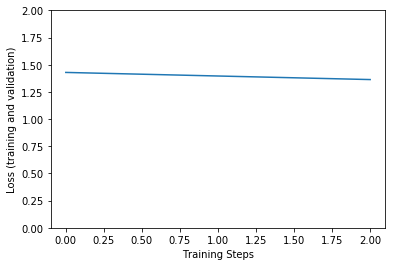

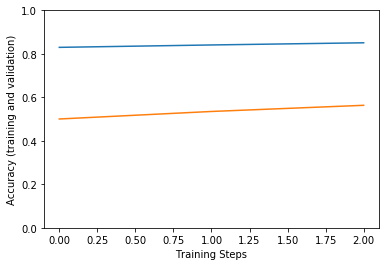

In [41]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [38]:
hist

{'accuracy': [0.82985216, 0.84089106, 0.8508385],
 'loss': [1.4290987213208197, 1.3962311056261618, 1.3634767802042203],
 'val_accuracy': [0.50039744, 0.53502584, 0.5633446],
 'val_loss': [2.695763185501857, 2.6466522813790934, 2.444194936695463]}

Finally, the trained model can be saved for deployment to TF Serving or TF Lite (on mobile) as follows.

In [42]:
saved_model_path = "./saved_lip_fill"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./saved_lip_fill/assets


INFO:tensorflow:Assets written to: ./saved_lip_fill/assets


In [ ]:
pred

In [ ]:
# model.evaluate_generator(generator=valid_generator,
# steps=STEP_SIZE_VALID)

# STEP_SIZE_TEST=valid_generator.n//valid_generator.batch_size
# valid_generator.reset()
# pred=model.predict_generator(valid_generator,
# steps=STEP_SIZE_TEST,
# verbose=1)

# predicted_class_indices=np.argmax(pred,axis=1)

# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]


filenames = valid_generator.filenames
nb_samples = len(filenames)

# # filenames = test_generator.filenames
# # nb_samples = len(filenames)

predict = model.predict_generator(valid_generator,steps = nb_samples,
verbose=1)
predicted_class_indices=np.argmax(predict,axis=1)

# model.predict_generator()

 5935/25196 [======>.......................] - ETA: 1:00:28

In [45]:

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

filenames = valid_generator.filenames
nb_samples = len(filenames)
predict = model.predict_generator(valid_generator,steps = nb_samples,
verbose=1)
predicted_class_indices=np.argmax(predict,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=valid_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

20148/20148 [==============================] - 3491s 173ms/step


ValueError: arrays must all be same length

In [46]:
filenames = valid_generator.filenames
nb_samples = len(filenames)
nb_samples

20148

In [49]:
len(predictions)


644364

## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TF Lite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TF Lite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like EdgeTPU.

In [ ]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("/tmp/lite_flowers_model", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))